In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
all_tweets = pd.read_csv('tweets.csv', usecols = ['timestamp', 'text'],encoding='latin1')  #nrows 'in_reply_to_status_id'

#filter out replies

#tweets_r = all_tweets['in_reply_to_status_id'] == ''
tweets = all_tweets

In [186]:
print(tweets[tweets['year'] == 2011])
print(tweets)

                                                   text  month  year
8515              why isn t egypt a  trendlocation          12  2011
8516  my dream  is to pray in  aqsa   it will happen...     12  2011
8526                             i want my mobile back      12  2011
8528  i don t accept follower requests from people i...     12  2011
8529  i m very curious   why 140 characters  eshme3n...     12  2011
...                                                 ...    ...   ...
9556                                                ...      5  2011
9559          walk for nile was such a succesful event       5  2011
9565                      grade seven  school spirit         3  2011
9569                             school spirit     lt 3      3  2011
9576                                         masr  lt 3      2  2011

[295 rows x 3 columns]
                                                   text  month  year
4     students are cheering  screaming  crying  and ...     12  2018
5         

In [4]:
#add cols for month and year
index = 0;

tweets['month'] = 0
tweets['year'] = 0

for i in tweets['timestamp']:
    tweets['year'][index]=tweets['timestamp'][index][0:4]
    index+=1
    
index = 0

for i in tweets['timestamp']:
    tweets['month'][index]=tweets['timestamp'][index][5:7]
    index+=1
    

del tweets['timestamp']

    
#print(tweets['year'])
#print(tweets['year'])
#print(tweets['month'])

C:\Users\aliae\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\aliae\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
#clean up text
tweets['text'] = tweets['text'].str.lower()
#tweets['text'] = tweets['text'].replace('[^a-zA-Z0-9]',' ', regex = True) #replace non letters or numbers

In [182]:
#tweets.where(filter1 & filter2, inplace = True)
#tweets_f = [c for c in tweets_text if tweets_text[0:2] != 'RT']


tweets = tweets[~tweets.text.str.contains("@")]
tweets = tweets[~tweets.text.str.contains("rt")]
tweets = tweets[~tweets.text.str.contains("plx11zpn21")]

tweets['text'] = tweets['text'].replace('[^a-zA-Z0-9]',' ', regex = True) #replace non letters or numbers


def tweets_by_year(year):
    is_year = tweets['year'] == year
    return tweets[is_year].sort_values(by=['month'])

tweets_2011 = tweets_by_year(2011)
tweets_2012 = tweets_by_year(2012)
tweets_2013 = tweets_by_year(2013)
tweets_2014 = tweets_by_year(2014)


'''
tweets_sub = tweets['year'] < 2015
tweets_x = tweets[tweets_sub]
'''

from collections import Counter

index = 0

alltweets = ''

'''
for i in tweets['text']:
    alltweets = alltweets + ' ' + tweets['text'][index]
    index+=1
'''

#stop_words = frozenset(STOPWORDS)
#split_it = alltweets.split() 
#Counter = Counter(split_it) 
#print(Counter.most_common(100))
print(tweets_2011)

                                                   text  month  year
9576                                         masr  lt 3      2  2011
9569                             school spirit     lt 3      3  2011
9565                      grade seven  school spirit         3  2011
9559          walk for nile was such a succesful event       5  2011
9556                                                ...      5  2011
...                                                 ...    ...   ...
8641        heal the world  make it a better place   mj     12  2011
8640            shewayet baltageya afalo el midan tany      12  2011
8638                                                        12  2011
8659                           mohamed beltagy  y   fjp     12  2011
8515              why isn t egypt a  trendlocation          12  2011

[295 rows x 3 columns]


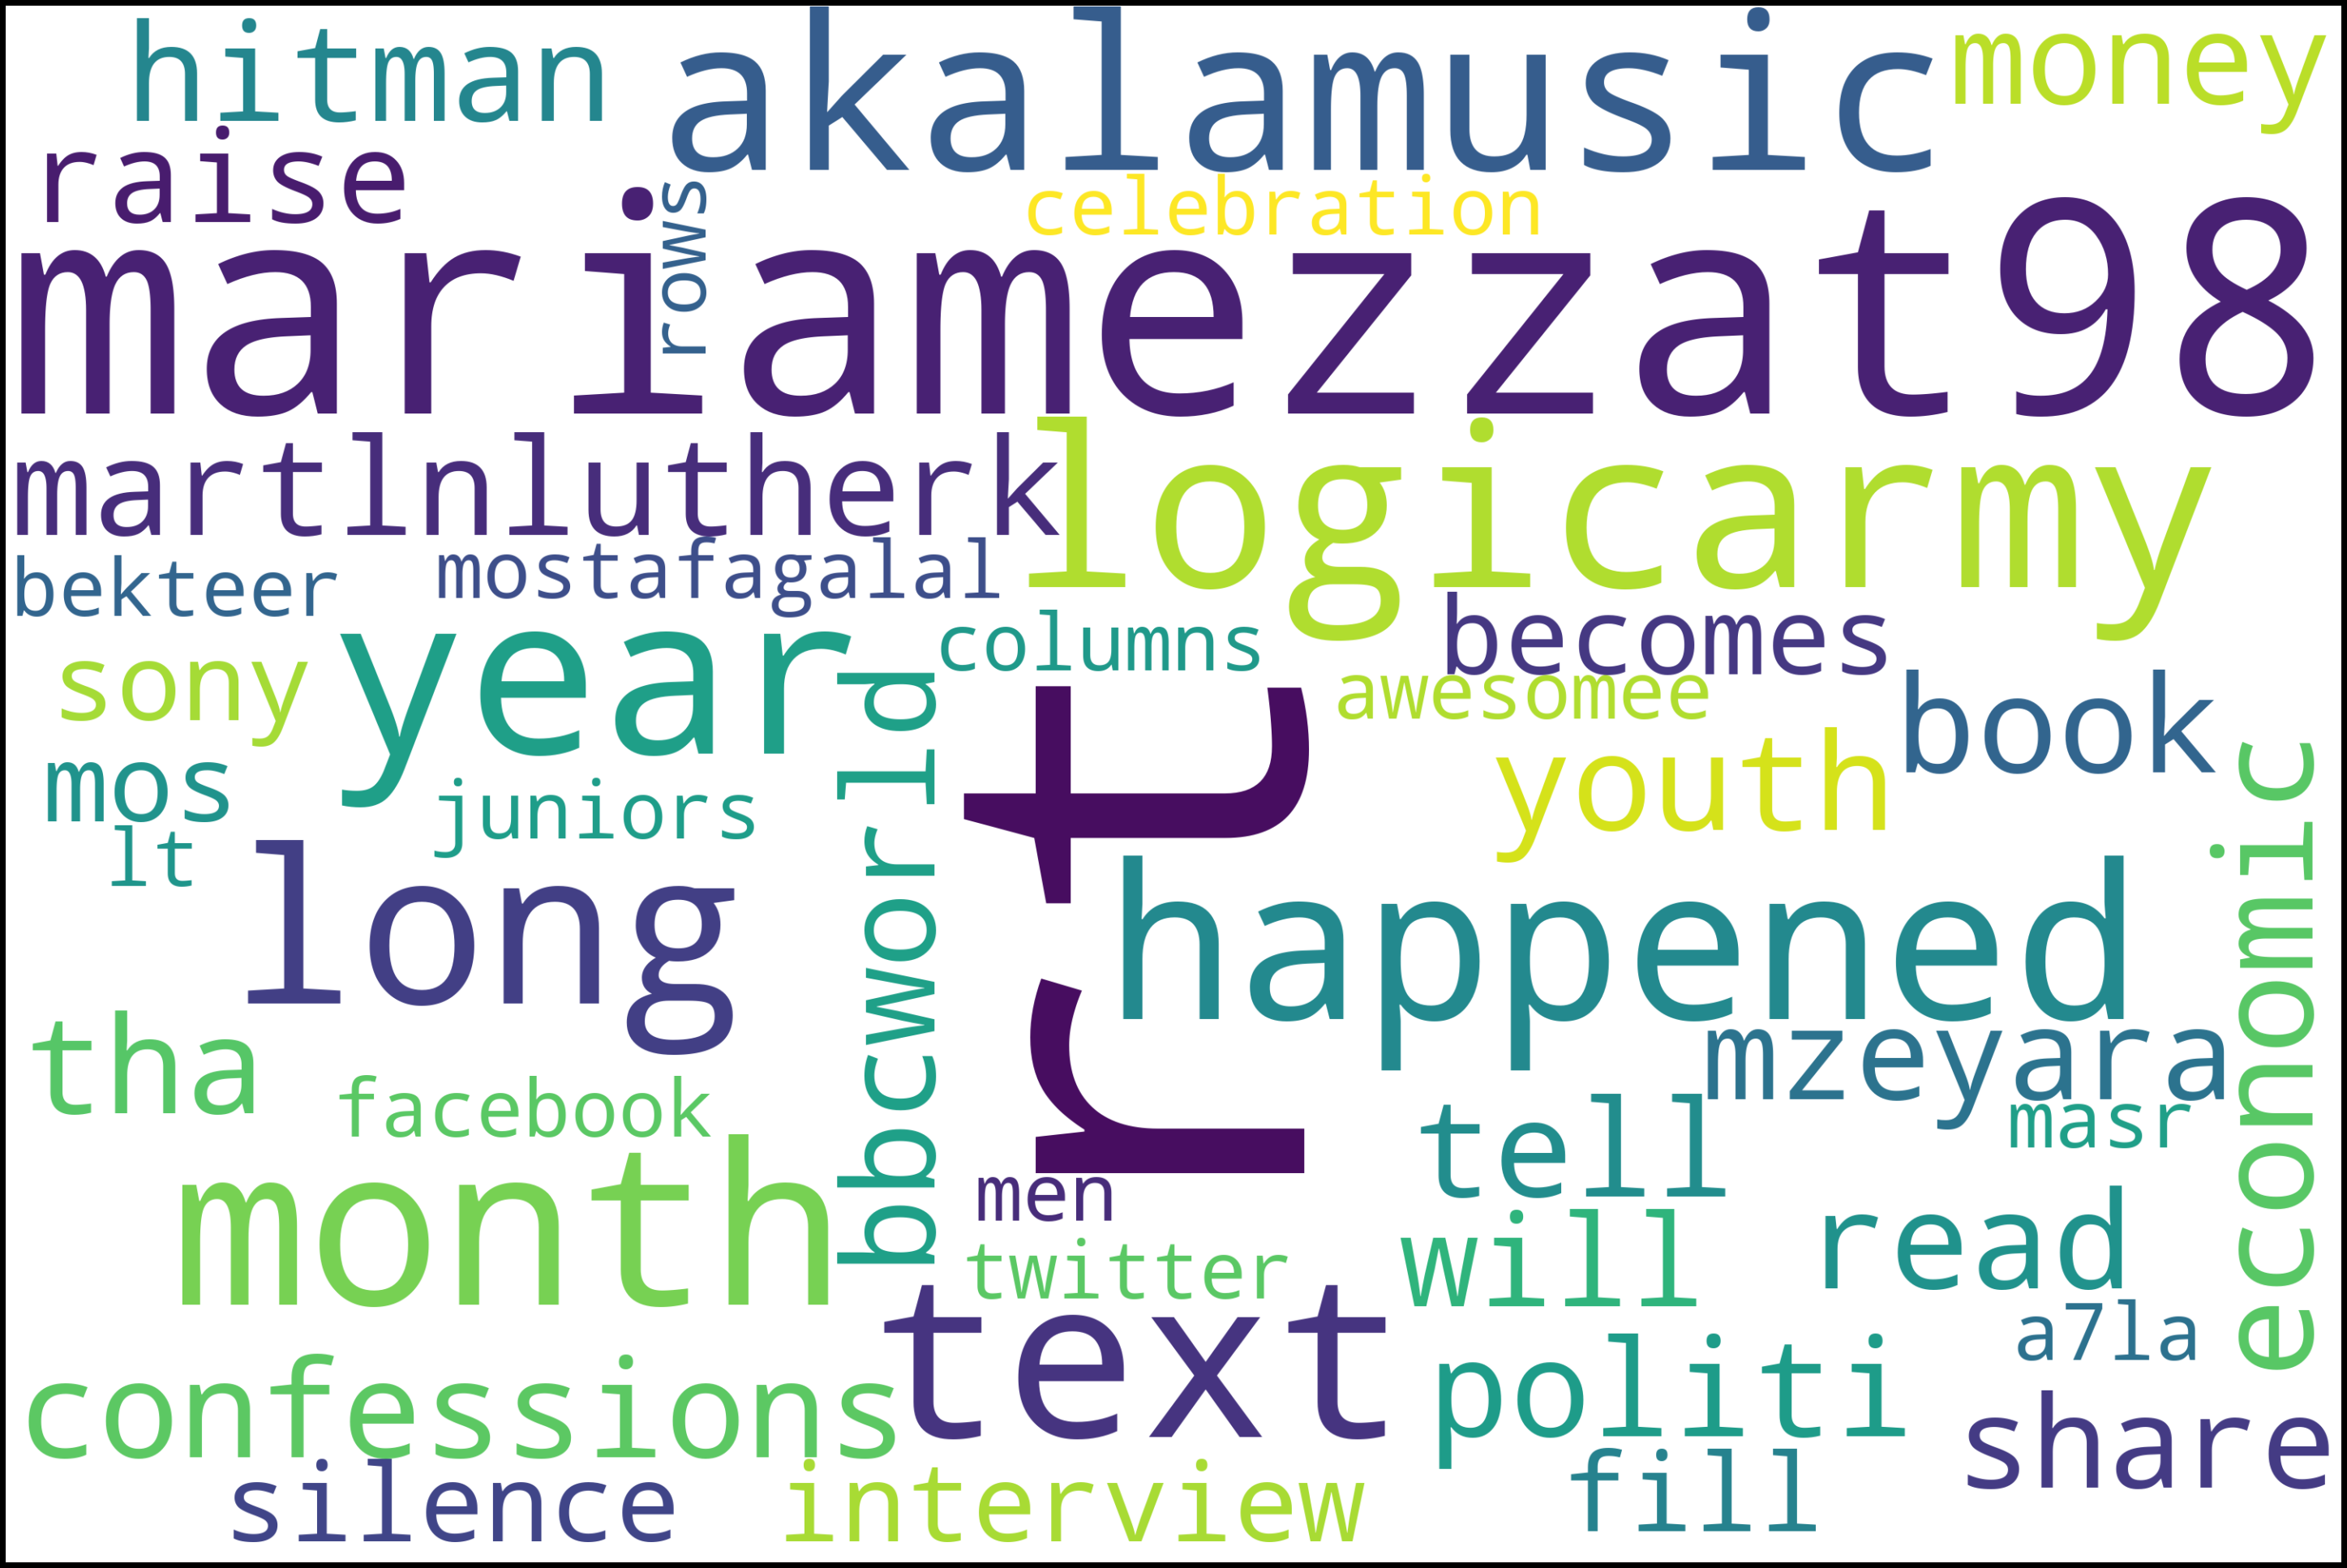

In [12]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS
).generate(str(tweets_x)
)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [24]:
tweets_4yrs = pd.concat([tweets_2011, tweets_2012, tweets_2013, tweets_2014])
print(tweets_4yrs)

                                                   text  month  year
9576                                         masr  lt 3      2  2011
9569                             school spirit     lt 3      3  2011
9565                      grade seven  school spirit         3  2011
9559          walk for nile was such a succesful event       5  2011
9556                                                ...      5  2011
...                                                 ...    ...   ...
2725                last minute goal by  sanchez   coyg     12  2014
2729           lowkey   special  http   t co avzagjkg6p     12  2014
2732  how can people be pro  sisi  but against  muba...     12  2014
2716                                                ...     12  2014
2698  confessions of an economic hitman   a book tha...     12  2014

[1799 rows x 3 columns]


In [ ]:
#print(tweets_2013_s)

def df_to_text(tweets):
    return tweets.text.str.cat(sep=' ')

def tweets_by_month(year):
    is_year = tweets['year'] == year
    return tweets[is_year].sort_values(by=['month'])

#for i in tweets['text']:
#alltweets = alltweets + ' ' + tweets['text'][index]
 ## index+=1

#stop_words = frozenset(STOPWORDS)

from collections import Counter

split_it = tweets_2011_t.split() 
Counter = Counter(split_it) 
#print(Counter.most_common(100))


#tweets_4yrs.to_csv(r'tweets_4years.csv')

In [ ]:
tweets_2011 = tweets_2011.reset_index()
del tweets_2011['index']

tweets_2012 = tweets_2012.reset_index()
del tweets_2012['index']

tweets_2013 = tweets_2013.reset_index()
del tweets_2013['index']

tweets_2014 = tweets_2014.reset_index()
del tweets_2014['index']tweets

In [181]:
#by_month_2011 = pd.DataFrame(columns=['year', 'month', 'count','text' ]) #, 'common_words', 'themes'
from collections import Counter

def tweets_by_month(tweets_year):
    #tweets_year=tweets_year.reset_index()
    #del tweets_year['index']
    stop_words = STOPWORDS
    num_rows = len(tweets_year.index)
    by_month = pd.DataFrame(index=np.arange(12), columns=['year', 'month', 'count','text','common_words'])
    
    by_month['month'][0]=tweets_year['month'][0]
    by_month['year'][0] = tweets_year['year'][0] 
    by_month['text'][0] = tweets_year['text'][0]
    by_month['count'][0] = 1
    
    ind_m = 0 
    ind_y = 1
    #range(num_rows)
    for i in range(num_rows-1):
        if tweets_year['month'][ind_y] > by_month['month'][ind_m]: #initialize new month
            split_it = by_month['text'][ind_m].split() 
            count = Counter(split_it) 
            for i in split_it:
                words = [w for w in split_it if w not in STOPWORDS and len(w) > 3]
                count.update(words)
            by_month['common_words'][ind_m]=count
            
            ind_m+=1
            by_month['month'][ind_m] = tweets_year['month'][ind_y]
            by_month['year'][ind_m] = tweets_year['year'][ind_y] 
            by_month['text'][ind_m] = tweets_year['text'][ind_y]
            by_month['count'][ind_m]=1
        else:
            #print("FALSE")
            by_month['count'][ind_m]+=1
            by_month['text'][ind_m]= by_month['text'][ind_m] + '; ' + tweets_year['text'][ind_y]
        ind_y = ind_y +1
    
    return by_month
    
by_month_2011 = tweets_by_month(tweets_2011)
by_month_2012 = tweets_by_month(tweets_2012)
by_month_2013 = tweets_by_month(tweets_2013)
by_month_2014 = tweets_by_month(tweets_2014)

tweets_by_month = pd.concat([by_month_2011, by_month_2012, by_month_2013, by_month_2014])
print(tweets_by_month)

tweets_by_month.to_csv(r'tweets_by_month.csv')

#tweets_2011 = tweets_2011.reset_index()

#print(tweets_2011['month'][24])


    year month count                                               text  \
0   2011     2     1                                         masr  lt 3   
1   2011     3     2  school spirit     lt 3; grade seven  school sp...   
2   2011     5     8  walk for nile was such a succesful event ;    ...   
3   2011     6    53  ahly fo2 el gamee3   ;  ineedtostop delaying t...   
4   2011     7    50  hamza namira   lt 3;  nowplaying   ew3edoony  ...   
5   2011     8    48   protectgaza  protectgaza  protectgaza  protec...   
6   2011     9    50  leih law 2olt ra2yak teb2a 5alas erhaaby   zap...   
7   2011    10    13  r i p steve jobs  great succesful person ; tab...   
8   2011    11    21   tomorrowisdecember trending    oh really  i d...   
9   2011    12    49  talent show   d; bored  ; so i open a webpage ...   
10   NaN   NaN   NaN                                                NaN   
11   NaN   NaN   NaN                                                NaN   
0   2012     1    22  i l

In [96]:
print(tweets_2011)

                                                   text  month  year
9576                                         masr  lt 3      2  2011
9569                             school spirit     lt 3      3  2011
9565                      grade seven  school spirit         3  2011
9559          walk for nile was such a succesful event       5  2011
9556                                                ...      5  2011
...                                                 ...    ...   ...
8641        heal the world  make it a better place   mj     12  2011
8640            shewayet baltageya afalo el midan tany      12  2011
8638                                                        12  2011
8659                           mohamed beltagy  y   fjp     12  2011
8515              why isn t egypt a  trendlocation          12  2011

[295 rows x 3 columns]


In [79]:
stop_words = STOPWORDS
split_2011 = tweets_2011_t.split()
split_2012 = tweets_2012_t.split()
split_2013= tweets_2013_t.split()
split_2014= tweets_2014_t.split()

from collections import Counter

def mostCommonWords(text):
    finalCount = Counter(text)
    for i in text:
        words = [w for w in text if w not in stop_words and len(w) > 3]
        finalCount.update(words)  # update final count using the words list
    return finalCount

#mostCommonWords(split_2011).most_common(20)
mostCommonWords(split_2012).most_common(20)
#mostCommonWords(split_2013).most_common(20)

[('syria', 381553),
 ('lowkey', 206944),
 ('tahrir', 200477),
 ('world', 174609),
 ('will', 155208),
 ('people', 135807),
 ('palestine', 129340),
 ('trending', 129340),
 ('never', 116406),
 ('mesh', 97005),
 ('3ashan', 97005),
 ('maherzain', 90538),
 ('ahly', 84071),
 ('free', 77604),
 ('ba2a', 77604),
 ('lehhayah', 71137),
 ('know', 71137),
 ('change', 71137),
 ('terrorist', 71137),
 ('shafik', 71137)]

In [19]:
print(tweets_4yrs)

                                                   text  month  year
9576                                         masr  lt 3      2  2011
9569                             school spirit     lt 3      3  2011
9565                      grade seven  school spirit         3  2011
9559          walk for nile was such a succesful event       5  2011
9556                                                ...      5  2011
...                                                 ...    ...   ...
2725                last minute goal by  sanchez   coyg     12  2014
2729           lowkey   special  http   t co avzagjkg6p     12  2014
2732  how can people be pro  sisi  but against  muba...     12  2014
2716                                                ...     12  2014
2698  confessions of an economic hitman   a book tha...     12  2014

[1799 rows x 3 columns]


                                                   text  month  year
2696  @logicarmy @akalamusic what happened to 'long ...     12  2014
2697  "@martlnlutherk: tell the youth to read politi...     12  2014
2698  confessions of an economic hitman.. a book tha...     12  2014
2699  rt @mzeyara: your share will raise money for s...     12  2014
2700  rt @bbcworld: the interview becomes sony's mos...     12  2014
...                                                 ...    ...   ...
9573  @mariamezzat98 can i fill the silence with you...      3  2011
9574  @mostafagalal juniors celebration was awesomee...      3  2011
9575               facebook a7la men twitter bekteer :@      2  2011
9576                                         masr &lt;3      2  2011
9577                            @mariamezzat98 why?? :(      2  2011

[6882 rows x 3 columns]
